## データ作成

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import cv2
import numpy as np

def generate_graph(n, p=0.3):
    # ランダムなグラフを生成（例: Erdős-Rényi グラフ）
    G = nx.erdos_renyi_graph(n=n, p=p)
    pos = nx.spring_layout(G, k=1)  # spring_layoutを使用

    return G, pos

def draw_graph(G, pos, figsize, **kwargs):
    # 描画
    fig, ax = plt.subplots(figsize=figsize)
    nx.draw(G, pos, ax=ax, **kwargs)

    # バッファに保存
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)  # 描画ウィンドウを閉じる（メモリ節約）

    # バッファをPIL Imageに変換
    buf.seek(0)
    img = Image.open(buf)

    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGBA2GRAY)

    return gray

In [3]:
import cv2

def get_node_bounding_box(node_img):
    # 画像を二値化
    _, binary_img = cv2.threshold(node_img, 200, 255, cv2.THRESH_BINARY_INV)

    # 輪郭を抽出
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # バウンディングボックスを取得
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
    
    # # バウンディングボックスを描画
    # for (x, y, w, h) in bounding_boxes:
    #     cv2.rectangle(node_img, (x, y), (x + w, y + h), (0, 0, 0), 2)
    # plt.imshow(node_img, cmap='gray')
    # plt.axis('off')  # 軸を非表示
    # plt.show()

    return bounding_boxes

def find_nearest_box_index(node_xy, box_centers, used_indices):
    """
    指定されたノード座標に最も近いボックスのインデックスを返す（未使用の中から）

    Args:
        node_xy (np.array): ノードのピクセル座標
        box_centers (list of np.array): 各ボックスの中心座標
        used_indices (set): すでに使用済みのボックスインデックス

    Returns:
        int or None: 最も近いボックスのインデックス、見つからなければ None
    """
    min_dist = float("inf")
    best_idx = None
    for i, center in enumerate(box_centers):
        if i in used_indices:
            continue
        dist = np.linalg.norm(node_xy - center)
        if dist < min_dist:
            min_dist = dist
            best_idx = i
    return best_idx

def normalize_coords_to_0_1(coords):
    """
    2次元座標の配列を [0, 1] に正規化する。

    Args:
        coords (np.ndarray): 形状 (N, 2) の座標配列（各行が (x, y)）

    Returns:
        np.ndarray: 正規化された座標配列（同じ形状で各軸が [0, 1] に正規化される）
    """
    min_vals = coords.min(axis=0)
    max_vals = coords.max(axis=0)
    denom = max_vals - min_vals
    denom[denom == 0] = 1.0  # 0除算防止

    return (coords - min_vals) / denom

def assign_boxes_to_nodes(node_positions, boxes):
    """
    ノード位置とバウンディングボックスの対応をとる

    Args:
        node_positions (dict): {node_id: np.array([x, y])}
        boxes (list of tuples): [(x, y, w, h)] 画像内のバウンディングボックス

    Returns:
        dict: {node_id: box} ノードと対応づけられたボックス
    """
    # ノード座標の正規化
    pos_coords = list(node_positions.values())
    pos_coords = np.array(pos_coords)
    normalize_pos_coords = normalize_coords_to_0_1(pos_coords)

    # 正規化済みノード辞書を構築
    normalized_pos = {
        k: v for k, v in zip(node_positions.keys(), normalize_pos_coords)
    }

    # ボックス中心座標を計算
    box_centers = np.array([
        [x + w / 2, y + h / 2] for (x, y, w, h) in boxes
    ])
    box_centers = normalize_coords_to_0_1(box_centers)

    # yを反転
    box_centers[:, 1] = 1 - box_centers[:, 1]

    matched = {}
    used_boxes = set()

    for node_id, node_xy in normalized_pos.items():
        best_idx = find_nearest_box_index(node_xy, box_centers, used_boxes)
        if best_idx is not None:
            matched[node_id] = boxes[best_idx]
            used_boxes.add(best_idx)

    return matched


# ノードのバウンディングボックスを描画
def draw_bounding_boxes(node_img, boxes, matched):
    for node_id, box in matched.items():
        x, y, w, h = box
        cv2.rectangle(node_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(node_img, str(node_id), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), 1)

    plt.imshow(node_img, cmap='gray')
    plt.axis('off')  # 軸を非表示
    plt.show()


{0: (160, 30, 15, 15), 1: (107, 68, 15, 15), 2: (31, 89, 15, 15), 3: (105, 117, 15, 15), 4: (157, 158, 15, 15)}


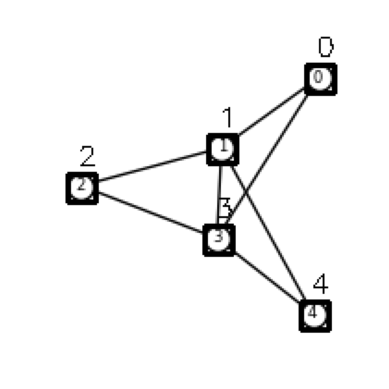

In [4]:
from itertools import combinations

def get_all_node_pairs(nodes):
    node_ids = list(nodes)
    return list(combinations(node_ids, 2))

G, pos = generate_graph(n=5, p=0.5)
img = draw_graph(G, pos, (2, 2), with_labels=True, node_color="white", edge_color="black",
        node_size=100, font_size=6, edgecolors="black")
node_img = draw_graph(G, pos, (2, 2), with_labels=False, node_color="white", edge_color="white",
        node_size=100, font_size=6, edgecolors="black")


boxes = get_node_bounding_box(node_img)
matched = assign_boxes_to_nodes(pos, boxes)
print(matched)
draw_bounding_boxes(img.copy(), boxes, matched)

pairs = get_all_node_pairs(G.nodes())
bound_pairs = [(matched[n1], matched[n2]) for n1, n2 in pairs]

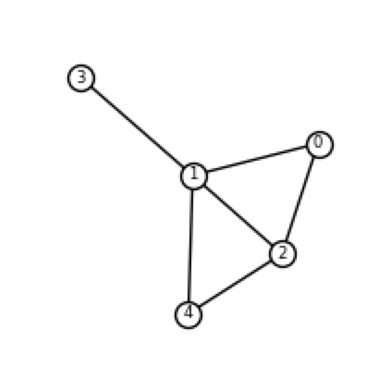

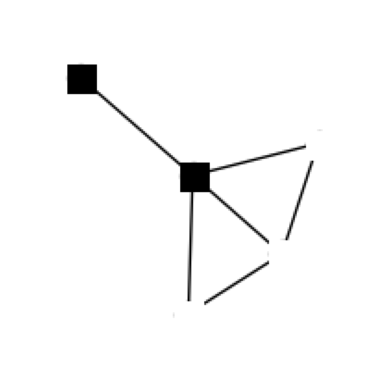

In [12]:
def draw_pair_highlight_image(img, node_pair, box_dict):
    """
    ノードペアのバウンディングボックスを黒塗りし、それ以外を白塗りする。

    Parameters:
        img (np.ndarray): 元の画像 (H, W, 3)
        node_pair (tuple): 注目するノードペア (node1, node2)
        box_dict (dict): {node_id: (x, y, w, h)} のバウンディングボックス辞書

    Returns:
        np.ndarray: 描画済みの画像
    """
    # 画像をコピー
    out_img = img.copy()

    pair_nodes = set(node_pair)

    for node_id, (x, y, w, h) in box_dict.items():
        if node_id in pair_nodes:
            color = (0, 0, 0)  # 黒塗り
        else:
            color = (255, 255, 255)  # 白塗り

        # 塗りつぶし矩形を描画
        cv2.rectangle(out_img, (x, y), (x + w, y + h), color, thickness=-1)

    return out_img

G, pos = generate_graph(n=5, p=0.5)

# 描画
img = draw_graph(G, pos, (2, 2), with_labels=True, node_color="white", edge_color="black",
        node_size=100, font_size=6, edgecolors="black")
node_img = draw_graph(G, pos, (2, 2), with_labels=True, node_color="white", edge_color="white",
        node_size=100, font_size=6, edgecolors="black")

plt.imshow(img, cmap='gray')
plt.axis('off')  # 軸を非表示
plt.show()

boxes = get_node_bounding_box(node_img)
matched = assign_boxes_to_nodes(pos, boxes)

pairs = get_all_node_pairs(G.nodes())
bound_pairs = [(matched[n1], matched[n2]) for n1, n2 in pairs]


result_img = draw_pair_highlight_image(img, (1, 3), matched)

plt.imshow(result_img, cmap="gray")
plt.axis("off")
plt.show()


In [44]:
def build_pair_highlight_dataset(
    num_graphs=100,
    n_nodes=5,
    p_edge=0.5,
):
    """
    ノードペアごとに、黒塗り画像 + ペア + ラベル を持つデータセットを構築

    Returns:
        samples (list): [
            {
                "image": np.ndarray,
                "pair": (node1, node2),
                "label": 0 or 1
            },
            ...
        ]
    """
    all_samples = []

    for _ in range(num_graphs):
        # グラフ生成
        G, pos = generate_graph(n=n_nodes, p=p_edge)

        # 画像生成（白黒）
        img = draw_graph(G, pos, figsize=(2, 2), with_labels=False,
                         node_color="white", edge_color="black",
                         node_size=100, font_size=6, edgecolors="black")

        node_img = draw_graph(G, pos, figsize=(2, 2), with_labels=False,
                              node_color="white", edge_color="white",
                              node_size=100, font_size=6, edgecolors="black")

        # バウンディングボックス取得
        boxes = get_node_bounding_box(node_img)

        # 正常にボックスが取れない場合スキップ
        if len(boxes) != len(G.nodes()):
            continue

        # ノードとボックスの対応
        matched = assign_boxes_to_nodes(pos, boxes)

        # ノードペア列挙
        pairs = get_all_node_pairs(G.nodes())

        for n1, n2 in pairs:
            # 画像にペアハイライトを適用
            highlight_img = draw_pair_highlight_image(img, (n1, n2), matched)

            highlight_img = cv2.cvtColor(highlight_img, cv2.COLOR_GRAY2RGB)
            highlight_img = highlight_img / 255

            # ラベル: エッジの有無
            label = int(G.has_edge(n1, n2))

            # サンプル登録
            sample = {
                "image": highlight_img,
                "pair": np.array((n1, n2)),
                "label": label
            }
            all_samples.append(sample)

    return all_samples

dataset = build_pair_highlight_dataset(num_graphs=5)


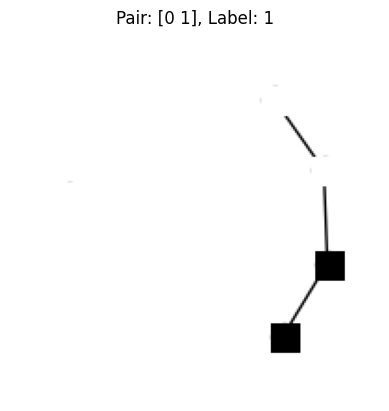

In [45]:
# 一つ表示して確認
import random
import matplotlib.pyplot as plt

sample = dataset[random.randint(0, 5)]
plt.imshow(sample["image"])
plt.title(f"Pair: {sample['pair']}, Label: {sample['label']}")
plt.axis("off")
plt.show()

In [ ]:
# データを確認

G, pos = generate_graph(n=5, p=0.5)

# 画像生成（白黒）
img = draw_graph(G, pos, figsize=(2, 2), with_labels=True,
                    node_color="white", edge_color="black",
                    node_size=100, font_size=6, edgecolors="black")

node_img = draw_graph(G, pos, figsize=(2, 2), with_labels=False,
                        node_color="white", edge_color="white",
                        node_size=100, font_size=6, edgecolors="black")

# バウンディングボックス取得
boxes = get_node_bounding_box(node_img)

# ノードとボックスの対応
matched = assign_boxes_to_nodes(pos, boxes)

# ノードペア列挙
pairs = get_all_node_pairs(G.nodes())

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


for n1, n2 in pairs:
    # 画像にペアハイライトを適用
    highlight_img = draw_pair_highlight_image(img, (n1, n2), matched)

    highlight_img = cv2.cvtColor(highlight_img, cv2.COLOR_GRAY2RGB)
    highlight_img = highlight_img / 255

    # ラベル: エッジの有無
    label = int(G.has_edge(n1, n2))

    sample = {
            "image": highlight_img,
            "pair": (n1, n2),
            "label": label
        }
    plt.imshow(sample["image"])
    plt.title(f"Pair: {sample['pair']}, Label: {sample['label']}")
    plt.axis("off")
    plt.show()

In [201]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class NodePairImageDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet基準
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = sample["image"]
        label = sample["label"]

        img_tensor = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return {
            "image": img_tensor,
            "label": label_tensor,
            "pair": sample["pair"]
        }


## モデルの作成と訓練

In [202]:
import torch.nn as nn
import torchvision.models as models

class PairEdgeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # EfficientNet を読み込み
        backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        
        # 分類ヘッドを除去（特徴抽出器として使う）
        self.feature_extractor = nn.Sequential(
            backbone.features,
            backbone.avgpool  # (B, 1280, 1, 1)
        )
        
        # 特徴次元
        self.flatten = nn.Flatten()  # (B, 1280)
        
        # 全結合層で2値分類
        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 0~1の確率出力
        )

    def forward(self, x):
        """
        x: (B, 3, H, W) の画像テンソル
        """
        feat = self.feature_extractor(x)
        feat = self.flatten(feat)           # (B, 1280)
        out = self.classifier(feat)         # (B, 1)
        return out

In [ ]:
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import copy
import torch

def train_model_with_early_stopping(
    model,
    dataset,
    batch_size=8,
    num_epochs=50,
    lr=1e-3,
    val_ratio=0.2,
    early_stopping_patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    # データ分割
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    early_stop_counter = 0
    best_model_state = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        # === Train ===
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
            images = batch["image"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)

            preds = model(images)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device).unsqueeze(1)

                preds = model(images)
                loss = criterion(preds, labels)

                val_loss += loss.item() * images.size(0)

                preds_bin = (preds > 0.5).float()
                correct += (preds_bin == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # === Early Stopping 判定 ===
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"  ↳ EarlyStopping Counter: {early_stop_counter}/{early_stopping_patience}")
            if early_stop_counter >= early_stopping_patience:
                print("  ↳ Early stopping triggered.")
                break

    # 最良モデルを復元
    model.load_state_dict(best_model_state)
    print("✅ Best model restored (based on val_loss).")

    return model  # 最良モデルを返す


# データセット構築（image, pair, label の辞書のリスト）
samples = build_pair_highlight_dataset(200)

# Dataset & モデル
dataset = NodePairImageDataset(samples)
model = PairEdgeClassifier()

# 訓練実行
model = train_model_with_early_stopping(model, dataset, num_epochs=50, batch_size=8)


[Train] Epoch 1: 100%|██████████| 200/200 [00:07<00:00, 27.76it/s]


Epoch 01 | Train Loss: 0.4894 | Val Loss: 0.4391 | Val Acc: 0.8325


[Train] Epoch 2: 100%|██████████| 200/200 [00:06<00:00, 28.98it/s]


Epoch 02 | Train Loss: 0.2725 | Val Loss: 0.1270 | Val Acc: 0.9600


[Train] Epoch 3: 100%|██████████| 200/200 [00:06<00:00, 29.19it/s]


Epoch 03 | Train Loss: 0.1958 | Val Loss: 0.1176 | Val Acc: 0.9600


[Train] Epoch 4: 100%|██████████| 200/200 [00:06<00:00, 29.07it/s]


Epoch 04 | Train Loss: 0.1785 | Val Loss: 0.0962 | Val Acc: 0.9625


[Train] Epoch 5: 100%|██████████| 200/200 [00:06<00:00, 28.98it/s]


Epoch 05 | Train Loss: 0.1486 | Val Loss: 0.1203 | Val Acc: 0.9575
  ↳ EarlyStopping Counter: 1/5


[Train] Epoch 6: 100%|██████████| 200/200 [00:06<00:00, 29.06it/s]


Epoch 06 | Train Loss: 0.1143 | Val Loss: 0.0858 | Val Acc: 0.9775


[Train] Epoch 7: 100%|██████████| 200/200 [00:06<00:00, 28.96it/s]


Epoch 07 | Train Loss: 0.1096 | Val Loss: 0.1107 | Val Acc: 0.9625
  ↳ EarlyStopping Counter: 1/5


[Train] Epoch 8: 100%|██████████| 200/200 [00:06<00:00, 28.85it/s]


Epoch 08 | Train Loss: 0.1128 | Val Loss: 0.0795 | Val Acc: 0.9775


[Train] Epoch 9: 100%|██████████| 200/200 [00:06<00:00, 29.09it/s]


Epoch 09 | Train Loss: 0.0792 | Val Loss: 0.2266 | Val Acc: 0.9775
  ↳ EarlyStopping Counter: 1/5


[Train] Epoch 10: 100%|██████████| 200/200 [00:06<00:00, 29.17it/s]


Epoch 10 | Train Loss: 0.0956 | Val Loss: 0.0710 | Val Acc: 0.9725


[Train] Epoch 11: 100%|██████████| 200/200 [00:06<00:00, 29.22it/s]


Epoch 11 | Train Loss: 0.0694 | Val Loss: 0.0834 | Val Acc: 0.9825
  ↳ EarlyStopping Counter: 1/5


[Train] Epoch 12: 100%|██████████| 200/200 [00:06<00:00, 29.05it/s]


Epoch 12 | Train Loss: 0.0575 | Val Loss: 0.0674 | Val Acc: 0.9850


[Train] Epoch 13: 100%|██████████| 200/200 [00:06<00:00, 29.06it/s]


Epoch 13 | Train Loss: 0.0649 | Val Loss: 0.0664 | Val Acc: 0.9850


[Train] Epoch 14: 100%|██████████| 200/200 [00:06<00:00, 28.98it/s]


Epoch 14 | Train Loss: 0.0518 | Val Loss: 0.0944 | Val Acc: 0.9700
  ↳ EarlyStopping Counter: 1/5


[Train] Epoch 15: 100%|██████████| 200/200 [00:06<00:00, 29.06it/s]


Epoch 15 | Train Loss: 0.0322 | Val Loss: 0.0620 | Val Acc: 0.9900


[Train] Epoch 16: 100%|██████████| 200/200 [00:06<00:00, 28.88it/s]


Epoch 16 | Train Loss: 0.0455 | Val Loss: 0.0575 | Val Acc: 0.9900


[Train] Epoch 17: 100%|██████████| 200/200 [00:06<00:00, 28.83it/s]


Epoch 17 | Train Loss: 0.0351 | Val Loss: 0.0774 | Val Acc: 0.9825
  ↳ EarlyStopping Counter: 1/5


[Train] Epoch 18: 100%|██████████| 200/200 [00:06<00:00, 28.59it/s]


Epoch 18 | Train Loss: 0.0506 | Val Loss: 0.0749 | Val Acc: 0.9850
  ↳ EarlyStopping Counter: 2/5


[Train] Epoch 19: 100%|██████████| 200/200 [00:06<00:00, 28.64it/s]


Epoch 19 | Train Loss: 0.0278 | Val Loss: 0.0432 | Val Acc: 0.9950


[Train] Epoch 20: 100%|██████████| 200/200 [00:06<00:00, 28.76it/s]


Epoch 20 | Train Loss: 0.0444 | Val Loss: 0.0793 | Val Acc: 0.9750
  ↳ EarlyStopping Counter: 1/5


[Train] Epoch 21: 100%|██████████| 200/200 [00:06<00:00, 29.10it/s]


Epoch 21 | Train Loss: 0.0334 | Val Loss: 0.0697 | Val Acc: 0.9900
  ↳ EarlyStopping Counter: 2/5


[Train] Epoch 22: 100%|██████████| 200/200 [00:06<00:00, 29.15it/s]


Epoch 22 | Train Loss: 0.0272 | Val Loss: 0.0678 | Val Acc: 0.9925
  ↳ EarlyStopping Counter: 3/5


[Train] Epoch 23: 100%|██████████| 200/200 [00:06<00:00, 29.12it/s]


Epoch 23 | Train Loss: 0.0067 | Val Loss: 0.0719 | Val Acc: 0.9925
  ↳ EarlyStopping Counter: 4/5


[Train] Epoch 24: 100%|██████████| 200/200 [00:06<00:00, 28.93it/s]


Epoch 24 | Train Loss: 0.0261 | Val Loss: 0.1267 | Val Acc: 0.9750
  ↳ EarlyStopping Counter: 5/5
  ↳ Early stopping triggered.
✅ Best model restored (based on val_loss).


## 結果検証

In [46]:
import torch
from torch.utils.data import DataLoader

def evaluate_model(model, dataset, threshold=0.5, batch_size=32, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    model = model.to(device)
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_probs = []
    all_labels = []
    all_pairs = []

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)
            pairs = batch["pair"]

            probs = model(images)  # (B, 1)
            preds = (probs > threshold).float()  # (B, 1)

            all_probs.extend(probs.cpu().numpy().flatten())
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            all_pairs.extend(pairs)

    return {
        "probs": all_probs,
        "preds": all_preds,
        "labels": all_labels,
        "pairs": all_pairs,
    }

from sklearn.metrics import accuracy_score, f1_score

samples = build_pair_highlight_dataset(100) 
dataset = NodePairImageDataset(samples)

results = evaluate_model(model, dataset, threshold=0.5)


acc = accuracy_score(results["labels"], results["preds"])
f1 = f1_score(results["labels"], results["preds"])

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9870
F1 Score: 0.9870


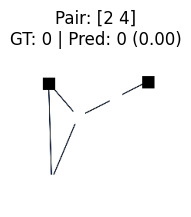

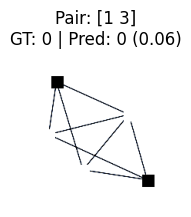

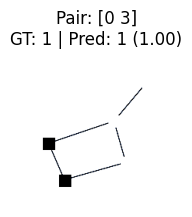

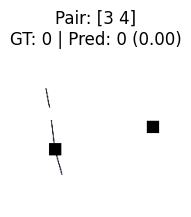

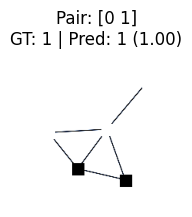

In [49]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

def denormalize(tensor, mean=[0.5], std=[0.5]):
    """正規化を打ち消す（逆変換）"""
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return tensor * std + mean


def show_predictions(dataset, results, num_samples=10):
    for i in range(min(num_samples, len(dataset))):
        i = random.randint(0, len(dataset))
        img_tensor = dataset[i]["image"]
        # 正規化を元に戻す
        img_tensor = denormalize(img_tensor).clamp(0, 1)
        img = transforms.ToPILImage()(img_tensor.cpu())

        label = results["labels"][i]
        pred = results["preds"][i]
        prob = results["probs"][i]
        pair = results["pairs"][i]
        pair = pair.numpy()

        plt.figure(figsize=(2, 2))
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Pair: {pair}\nGT: {int(label)} | Pred: {int(pred)} ({prob:.2f})")
        plt.show()


results = evaluate_model(model, dataset)
show_predictions(dataset, results, num_samples=5)


In [692]:
save_path = "models/PairEdgeClassifier.pth"

# モデルの状態を保存
torch.save(model.state_dict(), save_path)

In [212]:
model = PairEdgeClassifier()
model.load_state_dict(torch.load("models\PairEdgeClassifier.pth"))
model.to("cuda")
model.eval()  # 評価モードにする
print("モデルをロード")

モデルをロード


## 画像からグラフを作成

In [8]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms

# 画像とバウンディングボックスから、ノード同士がエッジでつながっているか判定
def has_edge(img, n1, n2, bounding_boxes, edge_classifier, device='cpu'):
    """
    img: numpy array, 元のグラフ画像（グレースケール）
    n1, n2: int, ノードのインデックス
    bounding_boxes: dict, ノードインデックス → (x, y, w, h)
    edge_classifier: nn.Module, 学習済みモデル
    device: 推論に使うデバイス（'cpu' or 'cuda'）
    """

    # ノードペアを強調した画像を作成（白黒画像）
    highlight_img = draw_pair_highlight_image(img, (n1, n2), bounding_boxes)
    
    # グレースケール → RGB
    highlight_img = cv2.cvtColor(highlight_img, cv2.COLOR_GRAY2RGB)

    # PyTorch Tensorに変換し、正規化
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet基準 この正規化じゃないと精度が大きく下がる
            std=[0.229, 0.224, 0.225]
        )
    ])

    input_tensor = transform(highlight_img).unsqueeze(0).to(device)  # (1, 3, H, W)

    # モデルを評価モードに
    edge_classifier.eval()

    with torch.no_grad():
        output = edge_classifier(input_tensor)
        prob = output.item()  # スカラーに変換

    return prob > 0.5, prob  # True/False（しきい値0.5）, 確率スコア

def generate_sample_data(n=5, p=0.5):
    G, pos = generate_graph(n, p)

    # 描画
    img = draw_graph(G, pos, (2, 2), with_labels=True, node_color="white", edge_color="black",
            node_size=100, font_size=6, edgecolors="black")
    node_img = draw_graph(G, pos, (2, 2), with_labels=True, node_color="white", edge_color="white",
            node_size=100, font_size=6, edgecolors="black")



    boxes = get_node_bounding_box(node_img)
    matched = assign_boxes_to_nodes(pos, boxes)

    pairs = get_all_node_pairs(G.nodes())
    return img, pairs, matched, G, pos

def img_to_graph(img, bounding_boxes, edge_model, device='cpu'):
    """
    入力画像とバウンディングボックス情報からnetworkxグラフを推定する。

    Parameters:
    ----------
    img : np.ndarray
        入力画像（グレースケール想定）
    bounding_boxes : dict[int, Tuple[int, int, int, int]]
        各ノードIDに対するバウンディングボックス (x, y, w, h)
    edge_model : torch.nn.Module
        2ノード間のエッジの有無を判定する学習済みモデル
    device : str
        推論に使用するデバイス（"cpu" or "cuda"）

    Returns:
    -------
    G : networkx.Graph
        推定されたグラフ構造
    edge_probs : dict[(int,int), float]
        各エッジ候補の存在確率。エッジがない場合でも確率は計算している
    """

    G = nx.Graph()
    node_ids = list(bounding_boxes.keys())
    G.add_nodes_from(node_ids)

    edge_probs = {}

    # すべてのノードペアに対してエッジを予測
    for n1, n2 in get_all_node_pairs(node_ids):
        is_connected, prob = has_edge(img, n1, n2, bounding_boxes, edge_model, device=device)
        edge_probs[(n1, n2)] = prob
        if is_connected:
            G.add_edge(n1, n2)

    return G, edge_probs

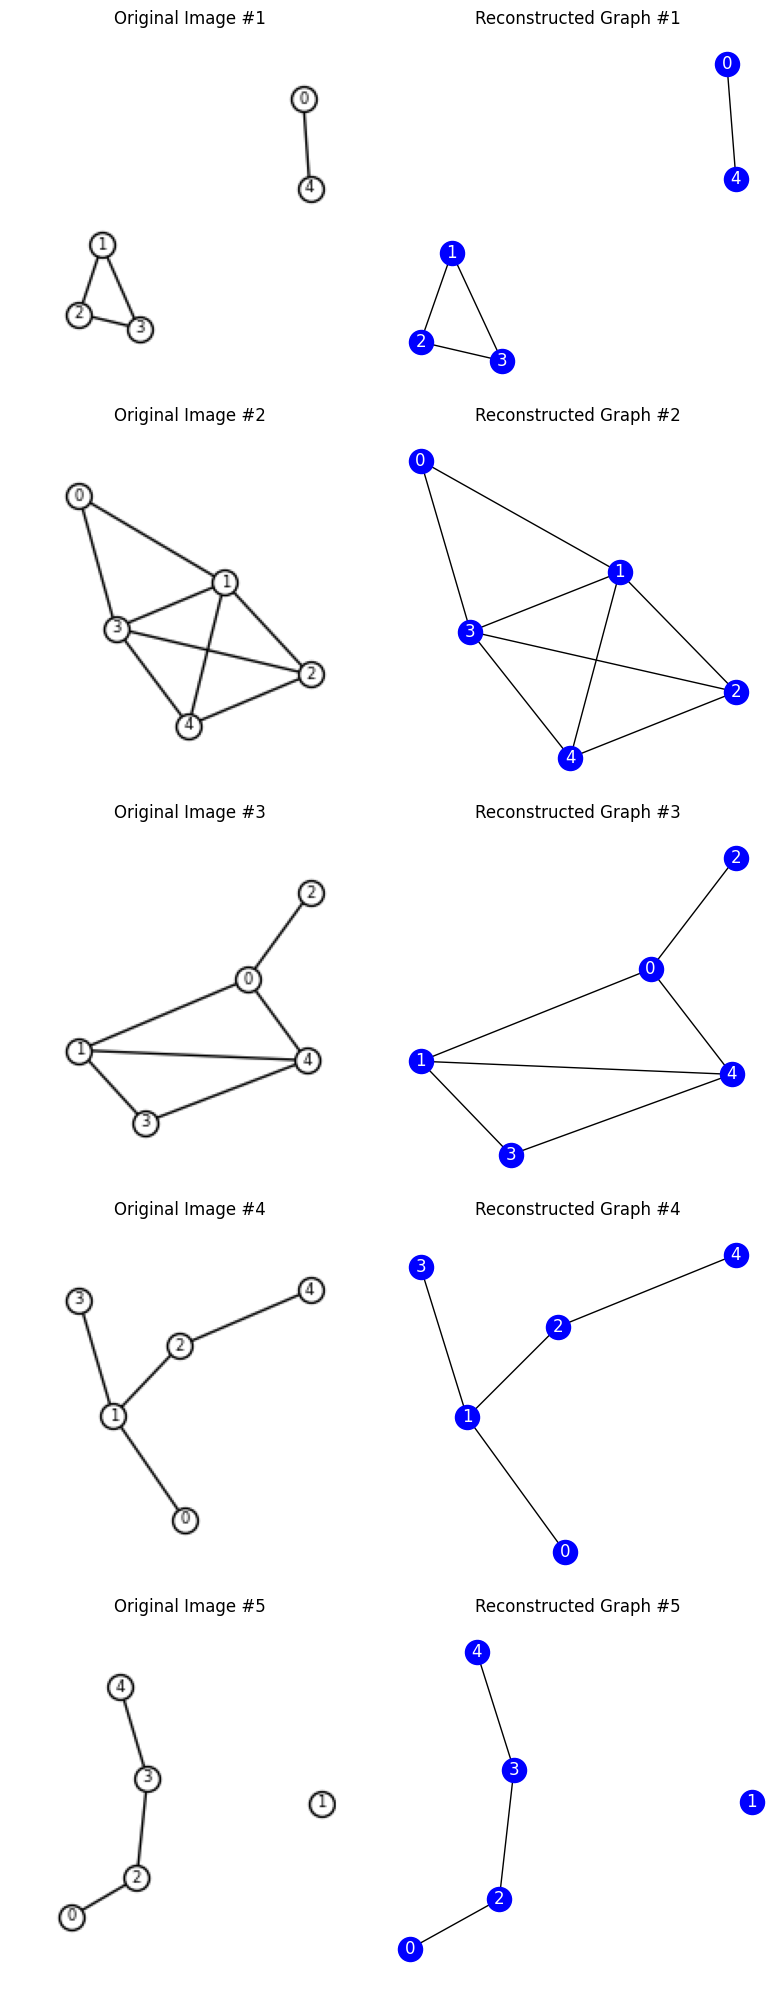

In [218]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_multiple_graphs(num_samples, model, device="cuda"):
    _, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

    for i in range(num_samples):
        # サンプルデータ生成（img, ペア, bounding_boxes, pos）
        img, _, matched, _, pos = generate_sample_data(n=5)

        # 元画像を表示
        ax_img = axes[i, 0] if num_samples > 1 else axes[0]
        ax_img.imshow(img, cmap="gray")
        ax_img.axis("off")
        ax_img.set_title(f"Original Image #{i+1}")

        # グラフ推定
        G, edge_probs = img_to_graph(img, matched, model, device=device)

        # 復元グラフ描画
        ax_graph = axes[i, 1] if num_samples > 1 else axes[1]
        ax_graph.clear()
        nx.draw(G, pos=pos, with_labels=True, font_color="white", node_color="blue", ax=ax_graph)

        # edge_labels = {(n1, n2): f"{edge_probs[(n1, n2)]:.2f}" for n1, n2 in G.edges()}
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', ax=ax_graph)

        ax_graph.set_title(f"Reconstructed Graph #{i+1}")
        ax_graph.axis("off")

    plt.tight_layout()
    plt.show()

# 使い方例
visualize_multiple_graphs(num_samples=5, model=model, device="cuda")


In [683]:
def graph_reconstruction_accuracy(model, num_samples=100, device="cuda"):
    correct = 0

    for _ in range(num_samples):
        img, _, matched, G_true, _ = generate_sample_data(n=5)
        G_pred, _ = img_to_graph(img, matched, model, device=device)

        # エッジ集合を比較（順序を無視した無向グラフとする）
        true_edges = set(frozenset(e) for e in G_true.edges())
        pred_edges = set(frozenset(e) for e in G_pred.edges())

        if true_edges == pred_edges:
            correct += 1

    accuracy = correct / num_samples
    print(f"Graph Reconstruction Accuracy: {accuracy:.3f} ({correct}/{num_samples})")
    return accuracy

graph_reconstruction_accuracy(model, num_samples=100, device="cuda")


Graph Reconstruction Accuracy: 0.890 (89/100)


0.89

In [686]:
def graph_reconstruction_metrics(model, num_samples=100, n=5,  device="cuda"):
    total_tp = 0
    total_fp = 0
    total_fn = 0

    for _ in range(num_samples):
        img, _, matched, G_true, _ = generate_sample_data(n)
        G_pred, _ = img_to_graph(img, matched, model, device=device)

        true_edges = set(frozenset(e) for e in G_true.edges())
        pred_edges = set(frozenset(e) for e in G_pred.edges())

        tp = len(true_edges & pred_edges)
        fp = len(pred_edges - true_edges)
        fn = len(true_edges - pred_edges)

        total_tp += tp
        total_fp += fp
        total_fn += fn

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    return f1

# 使い方
graph_reconstruction_metrics(model, num_samples=100, device="cuda")


Precision: 0.998
Recall: 0.990
F1 Score: 0.994


0.9941634241245136

n = 4
Precision: 0.997
Recall: 0.981
F1 Score: 0.989
n = 5
Precision: 0.988
Recall: 0.973
F1 Score: 0.981
n = 6
Precision: 0.960
Recall: 0.967
F1 Score: 0.964
n = 7
Precision: 0.883
Recall: 0.973
F1 Score: 0.926
n = 8
Precision: 0.786
Recall: 0.964
F1 Score: 0.866
n = 9
Precision: 0.697
Recall: 0.940
F1 Score: 0.800
n = 10
Precision: 0.627
Recall: 0.941
F1 Score: 0.753


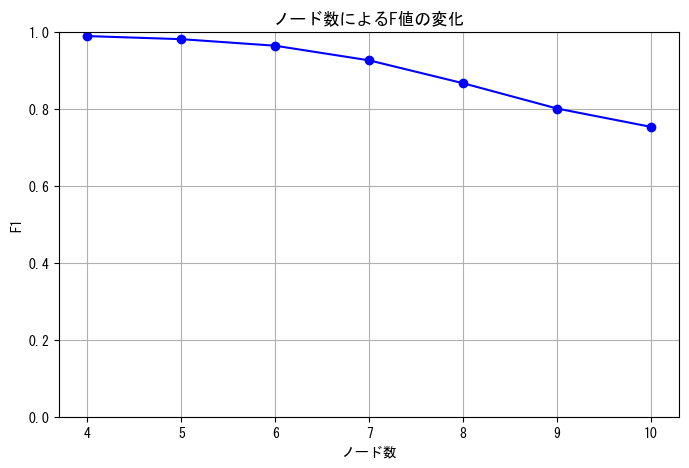

In [687]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# フォント設定（日本語を表示するため）
mpl.rcParams['font.family'] = 'MS Gothic'

# F1スコアを格納する辞書
f1_per_n = {}

# ノード数 n を 4〜10 に変化させて F1 を測定
for n in range(4, 11):
    print(f"n = {n}")
    f1 = graph_reconstruction_metrics(model, num_samples=100, n=n, device="cuda")
    f1_per_n[n] = f1

# グラフ表示
plt.figure(figsize=(8, 5))
plt.plot(list(f1_per_n.keys()), list(f1_per_n.values()), marker='o', color='blue')
plt.title("ノード数によるF値の変化")
plt.xlabel("ノード数")
plt.ylabel("F1")
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()


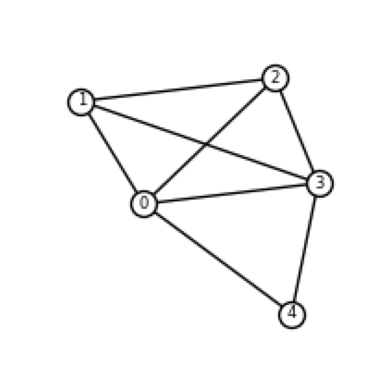

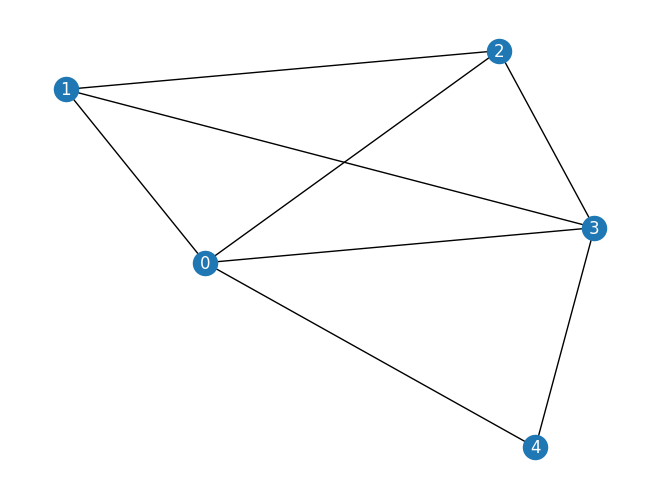

In [26]:
# 単体のグラフを再構築
img, _, matched, G, pos = generate_sample_data(n=5)

# 元画像を表示
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# グラフ推定
G_recon, edge_probs = img_to_graph(img, matched, model, device="cuda")
nx.draw(G_recon, pos, with_labels=True, font_color="white")
plt.show()

## 手書き画像からグラフ再構築

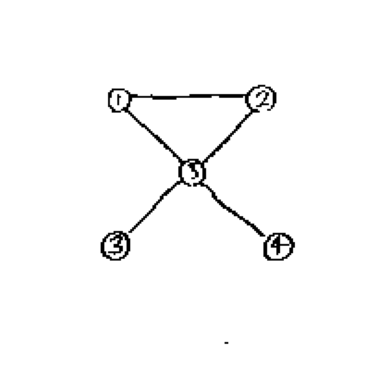

In [198]:
import cv2
import matplotlib.pyplot as plt

path = "img/tegaki1.png"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

resized = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)

# 二値化 (しきい値は調整)
_, binary = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)

# 二値化画像を表示
plt.imshow(binary, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
def select_rectangles(image):
    """ユーザーがバウンディングボックスを選択し、リストとして返す"""
    global points, rectangles
    points = []
    rectangles = []

    def mouse_callback(event, x, y, flags, param):
        global points, rectangles
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            if len(points) == 2:
                x1, y1 = points[0]
                x2, y2 = points[1]
                x_min, y_min = min(x1, x2), min(y1, y2)
                x_max, y_max = max(x1, x2), max(y1, y2)
                w, h = x_max - x_min, y_max - y_min
                rectangles.append((x_min, y_min, w, h))
                print(f"Rect: x={x_min}, y={y_min}, w={w}, h={h}")
                points = []

    cv2.namedWindow("image")
    cv2.setMouseCallback("image", mouse_callback)

    while True:
        temp = image.copy()
        for (x, y, w, h) in rectangles:
            cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.imshow("image", temp)
        key = cv2.waitKey(1)
        if key == 27:  # Escキー
            break

    cv2.destroyAllWindows()
    return rectangles

rects = select_rectangles(binary) # ノード番号順に囲む
# ノードIDを 1 から開始して辞書に
boxes = {i + 1: rects[i] for i in range(len(rects))}
boxes

Rect: x=49, y=39, w=18, h=21
Rect: x=124, y=37, w=22, h=22
Rect: x=45, y=116, w=23, h=23
Rect: x=134, y=117, w=24, h=21
Rect: x=87, y=75, w=22, h=23


{1: (49, 39, 18, 21),
 2: (124, 37, 22, 22),
 3: (45, 116, 23, 23),
 4: (134, 117, 24, 21),
 5: (87, 75, 22, 23)}

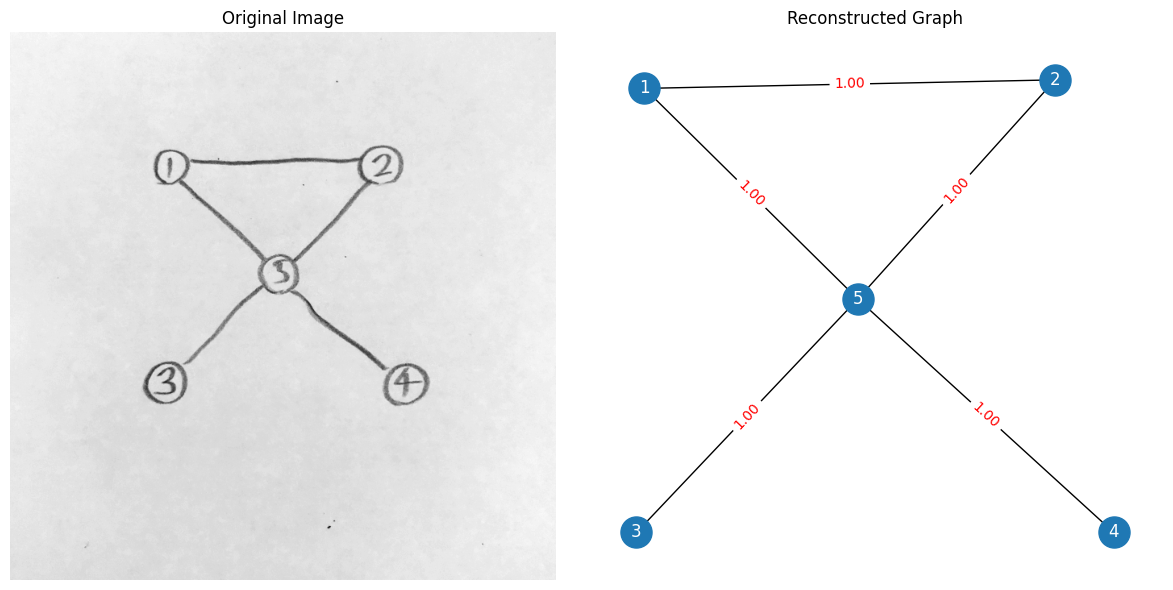

In [209]:
# 画像の高さ（Y反転に使用）
height = img.shape[0]

# 中心点を計算して pos を作成
# y座標は反転
pos = {
    node_id: (x + w / 2, height - (y + h / 2))
    for node_id, (x, y, w, h) in boxes.items()
}

# グラフ推定
G_recon, edge_probs = img_to_graph(binary, boxes, model, device="cuda")

# サブプロットを横に並べて作成
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 左：元画像
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# 右：再構成されたグラフ
nx.draw(G_recon, pos, ax=axes[1], with_labels=True, font_color="white", node_size=500)
edge_labels = {(n1, n2): f"{edge_probs[(n1, n2)]:.2f}" for n1, n2 in G_recon.edges()}
nx.draw_networkx_edge_labels(G_recon, pos, edge_labels=edge_labels, font_color='red', ax=axes[1])
axes[1].set_title("Reconstructed Graph")
axes[1].axis("off")

plt.tight_layout()
plt.show()